In [1]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import pandas as pd
import numpy as np

import forgi
import re
from os import path, chdir

from subprocess import Popen, PIPE

import matplotlib.pyplot as plt
from matplotlib import colors, cm
from mplotlib_addcolors import plot_rna_addcolors

#this script requires matplotlib==3.5.1 and viennaRNA package

In [2]:
chdir("/home/ledum/data/LshCas13a_RNA_cleavage/LshCas13a_5_min/")

In [3]:
LRTTableFile = "Results/Tables/TCS_detection_tables/LRTest_table_and_genome_features.tsv"
EcoliChrFile = "Reference_sequences/NC_000913.3.fasta"
NormCountsTableFile = "Results/Tables/Merged_ends_counts/N5E_T_vs_NT_CPM_normalized.tsv.gz"

SubsequencesFastaDir = "secondary_structures/SubsequencesFasta/"
SubsequencesDBNDir = "secondary_structures/SubsequencesDBN/"
RNAPicturesDir = "secondary_structures/Pictures/"

In [4]:
LRTTable = pd.read_csv(LRTTableFile, sep="\t")
LRTTable.sort_values(by="PValue.adj", ascending=True, inplace=True, ignore_index=True)
EcoliChrSeq = SeqIO.read(EcoliChrFile, "fasta").seq.transcribe()

NormCountsTable = pd.read_csv(NormCountsTableFile, sep="\t")

In [5]:
def extract_adj_seqs(seq, pos, strand, width):
    assert (strand in ["+", "-"]), "Invalid strand value"
    #should be 0-based coordinates
    if strand == "+":
        seq_slice = seq[pos-width : pos+width]
    elif strand == "-":
        seq_slice = seq[pos-width+1 : pos+width+1].reverse_complement()
    return(seq_slice)

In [6]:
def get_colors_array(Table, SeqID, pos, strand, width):
    if strand == "+":
        pos_array = np.arange(pos-width, pos+width)
        TableSubset = Table[(Table["SeqID"] == SeqID) & (Table["Strand"] == strand) & (Table["Pos"].isin(pos_array))]
        TableSubset_sorted = TableSubset.sort_values(by="Pos", ascending=True, ignore_index=True)
        logFC_values = TableSubset_sorted["aveLogFC"].tolist()
        
    elif strand == "-":
        pos_array = np.arange(pos-width+1, pos+width+1)
        TableSubset = Table[(Table["SeqID"] == SeqID) & (Table["Strand"] == strand) & (Table["Pos"].isin(pos_array))]
        TableSubset_sorted = TableSubset.sort_values(by="Pos", ascending=False, ignore_index=True)
        logFC_values = TableSubset_sorted["aveLogFC"].tolist()
    
    cmap = cm.Reds
    norm = colors.Normalize(vmin=min(logFC_values), vmax=max(logFC_values))
    colors_array = [cmap(norm(x)) for x in logFC_values]
    colorbar_settings = cm.ScalarMappable(norm=norm, cmap=cmap)
    colorbar_settings.set_array(logFC_values)
    
    return(colors_array, colorbar_settings)

In [7]:
def GetColorsAnnotatedRNAStructures(Table, Width):
    ColorsAnnotatedRNAStructures = list()

    for i, row in Table.iterrows():
        record_id = f'{row["MatchedFeatureGene"]}_{row["Pos"]}_{row["Strand"]}_'
        #extract subsequence; coordinates are 0-based
        record_seq = extract_adj_seqs(seq=EcoliChrSeq,
                                      pos=row["Pos"]-1,
                                      strand=row["Strand"],
                                      width=Width)
        record = SeqRecord(id=record_id,
                         name=record_id,
                         description=f'{row["MatchedFeatureDescription"]} fragment', 
                         seq=record_seq)
        #write subsequence to separate fasta file
        RNAFragmentsOutputFile = path.join(SubsequencesFastaDir, f"{record_id}.fasta")
        with open(RNAFragmentsOutputFile, "w") as hRNAFragmentsOutputFile:
            SeqIO.write(sequences=record, handle=hRNAFragmentsOutputFile, format="fasta")
        #run RNAfold program, remove energy info from the output (save it) and write dot-bracket notation to file
        DotBracketNotationFile = path.join(SubsequencesDBNDir, f"{record_id}.dbn")
        energy_pattern = r"\((..\d+.+)\)"
        energy_value = None 
        with open(DotBracketNotationFile, "w") as hDotBracketNotationFile:
            RNAfoldProc = Popen(["RNAfold", "--noPS", RNAFragmentsOutputFile], stdout=PIPE)
            for line in RNAfoldProc.stdout:
                energy_match = re.search(energy_pattern, line.decode("ascii"))
                if energy_match:
                    energy_value = energy_match.group(1)
                hDotBracketNotationFile.write(re.sub(energy_pattern, "", line.decode("ascii")))
        #read DBN file
        ForgiRecord = forgi.load_rna(DotBracketNotationFile, allow_many=False)
        #calculate colors for the heatmap
        #here coordinates are 1-based
        colors_array, cb_settings = get_colors_array(Table=NormCountsTable, 
                                                    SeqID=row["SeqID"], 
                                                    pos=row["Pos"], 
                                                    strand=row["Strand"], 
                                                    width=Width)
        #append the collected data to the array
        ColorsAnnotatedRNAStructures.append({"id" : record_id, 
                                             "ForgiRecord" : ForgiRecord, 
                                             "energy" : energy_value, 
                                             "colors" : colors_array, 
                                             "cb_settings" : cb_settings})
    return(ColorsAnnotatedRNAStructures)

In [8]:
def plot_rna_wrapper(record, label, outputfilepathprefix):
    figure, ax = plt.subplots(figsize=(20, 20))

    plot_rna_addcolors(record["ForgiRecord"], 
                       ax=ax, 
                       text_kwargs={"fontweight":"black"}, 
                       lighten=0, 
                       backbone_kwargs={"linewidth":1}, 
                       colorlist=record["colors"], 
                       annotations=None)

    cbar = figure.colorbar(record["cb_settings"], fraction = 0.03)
    cbar.set_label("log$_2$FC", size=20)
    cbar.ax.tick_params(labelsize=20)

    ax.set_title(label, weight="bold", horizontalalignment="left", position=(0.01, 0.95))
    
    figure.savefig(f"{outputfilepathprefix}_.png", dpi=100)
#     figure.savefig(f"{outputfilepathprefix}_.svg", dpi=100)

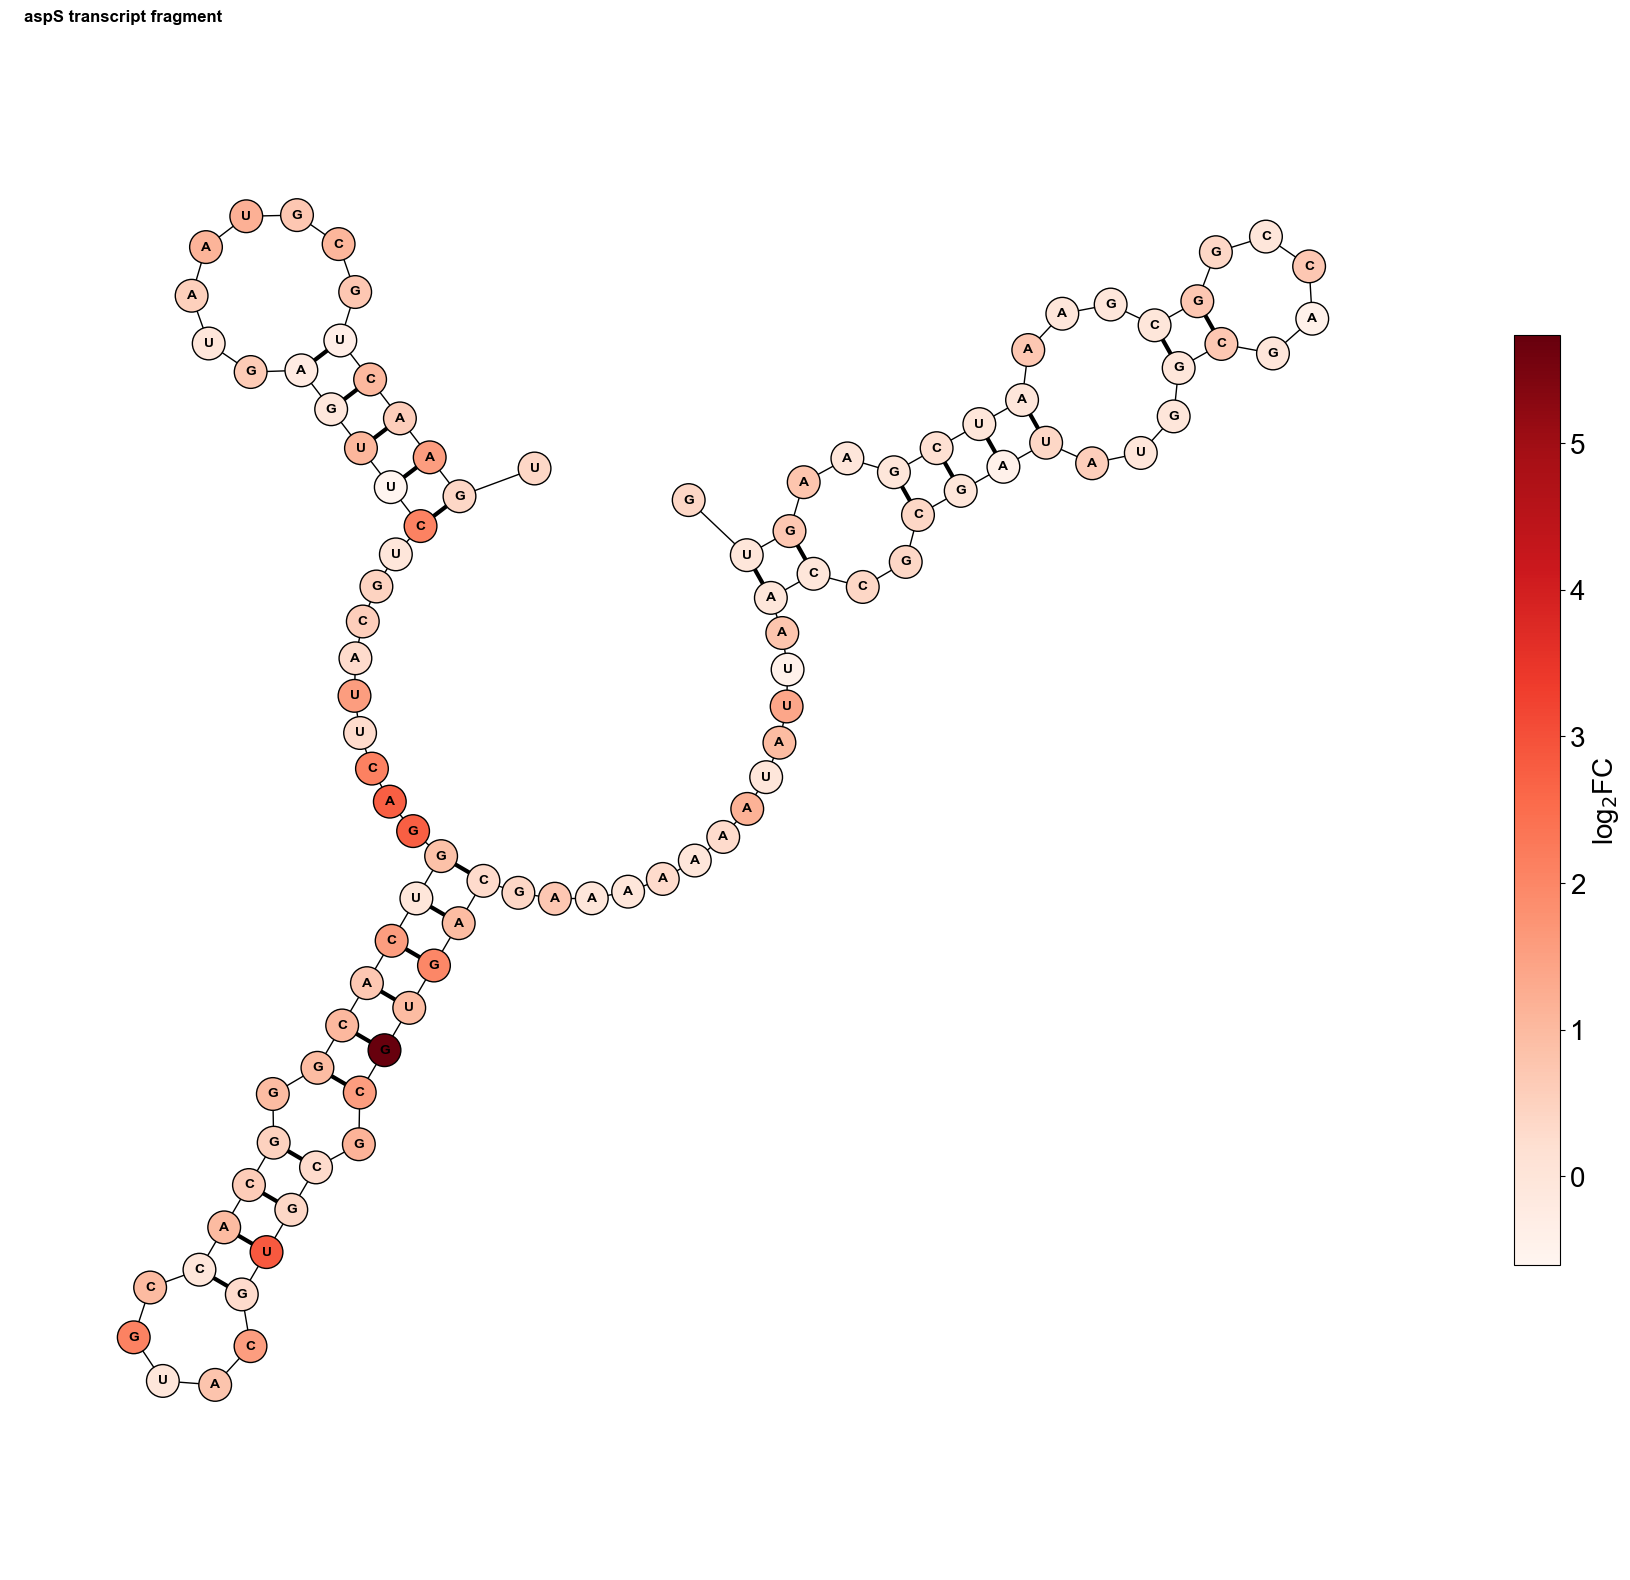

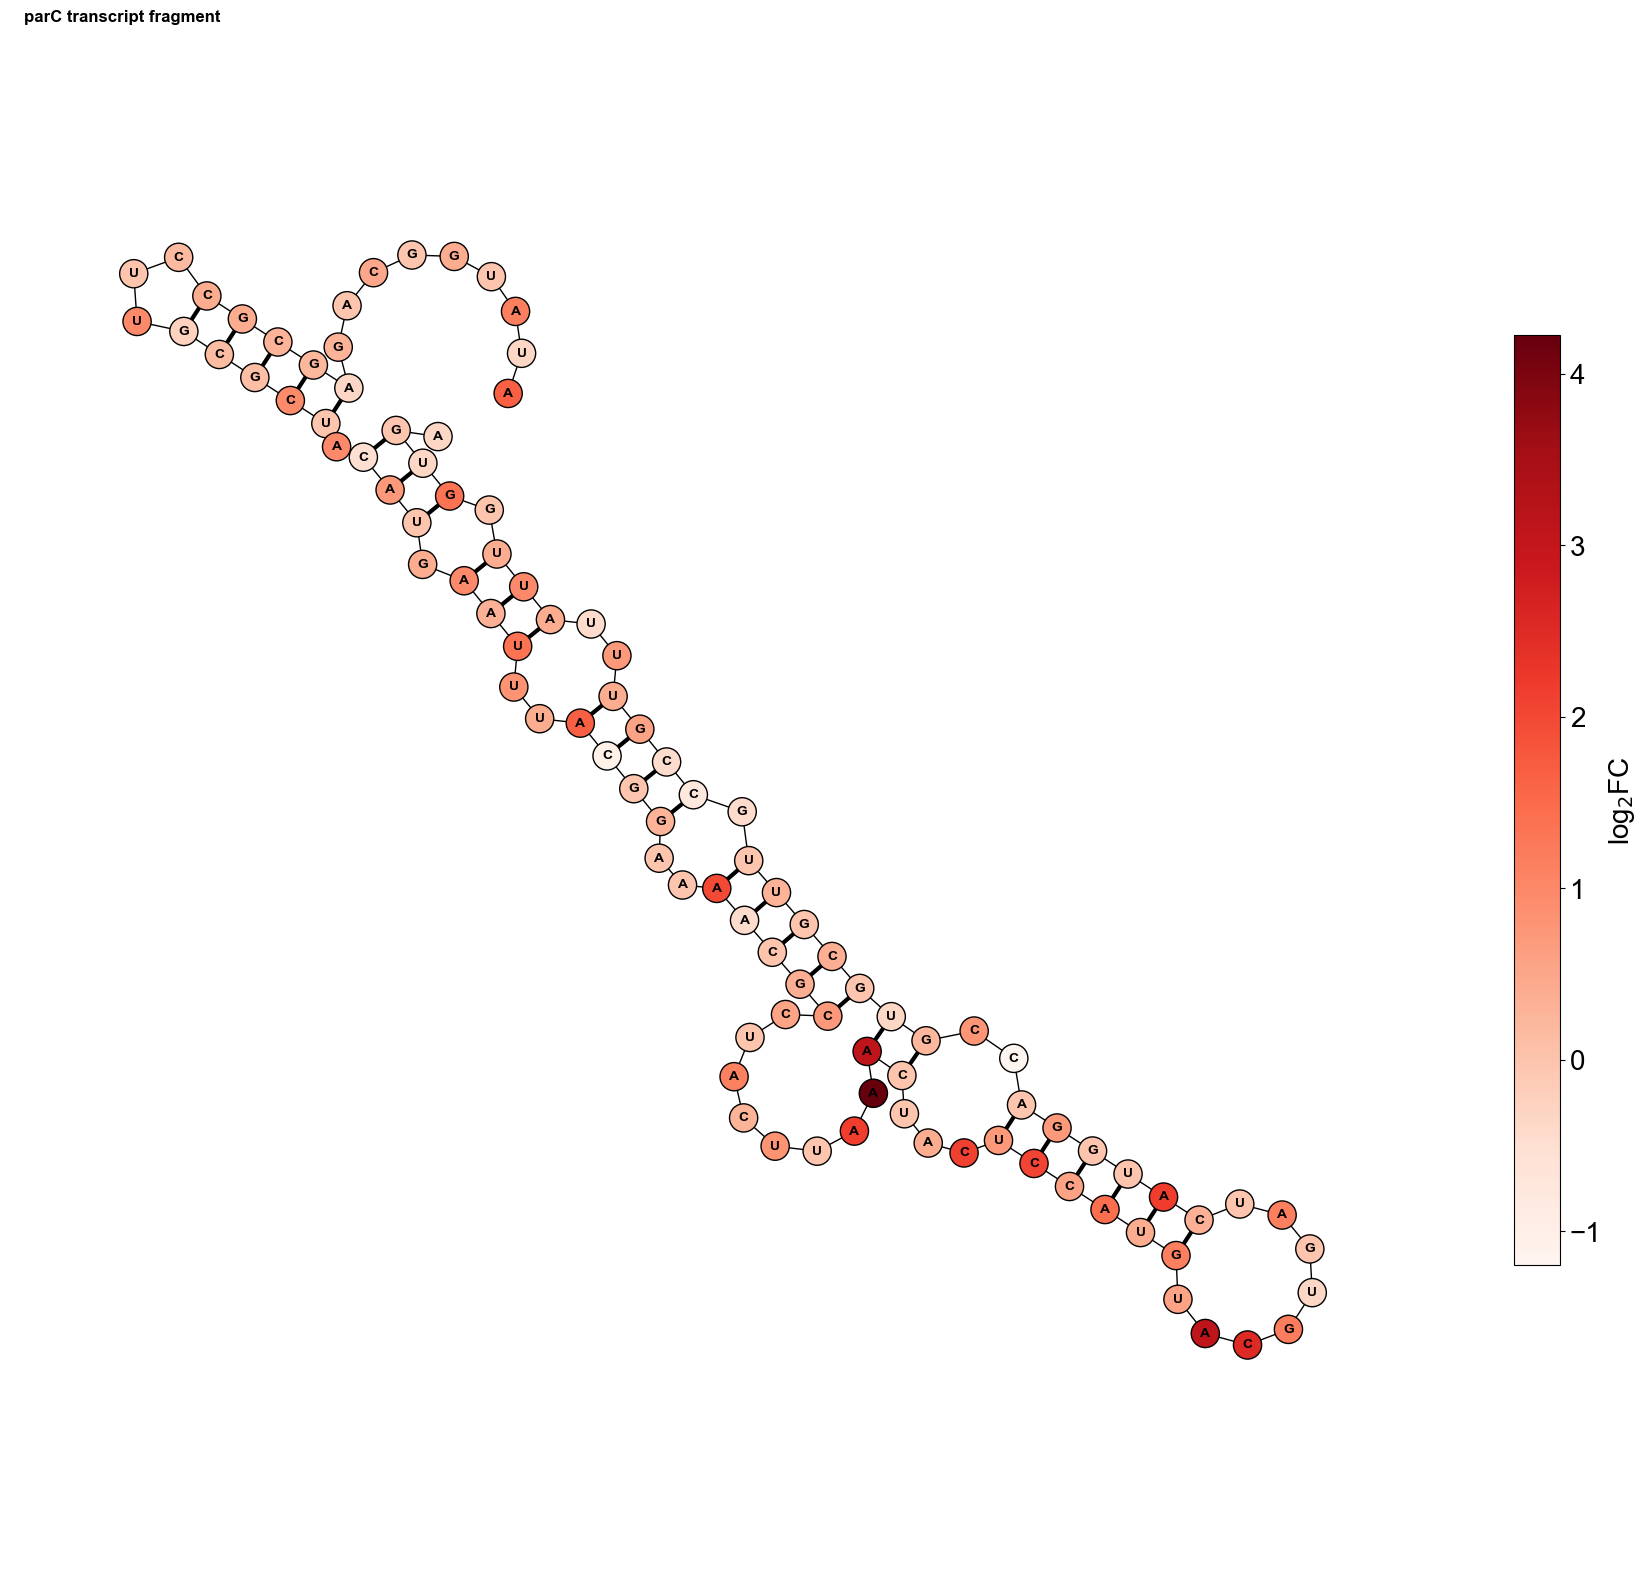

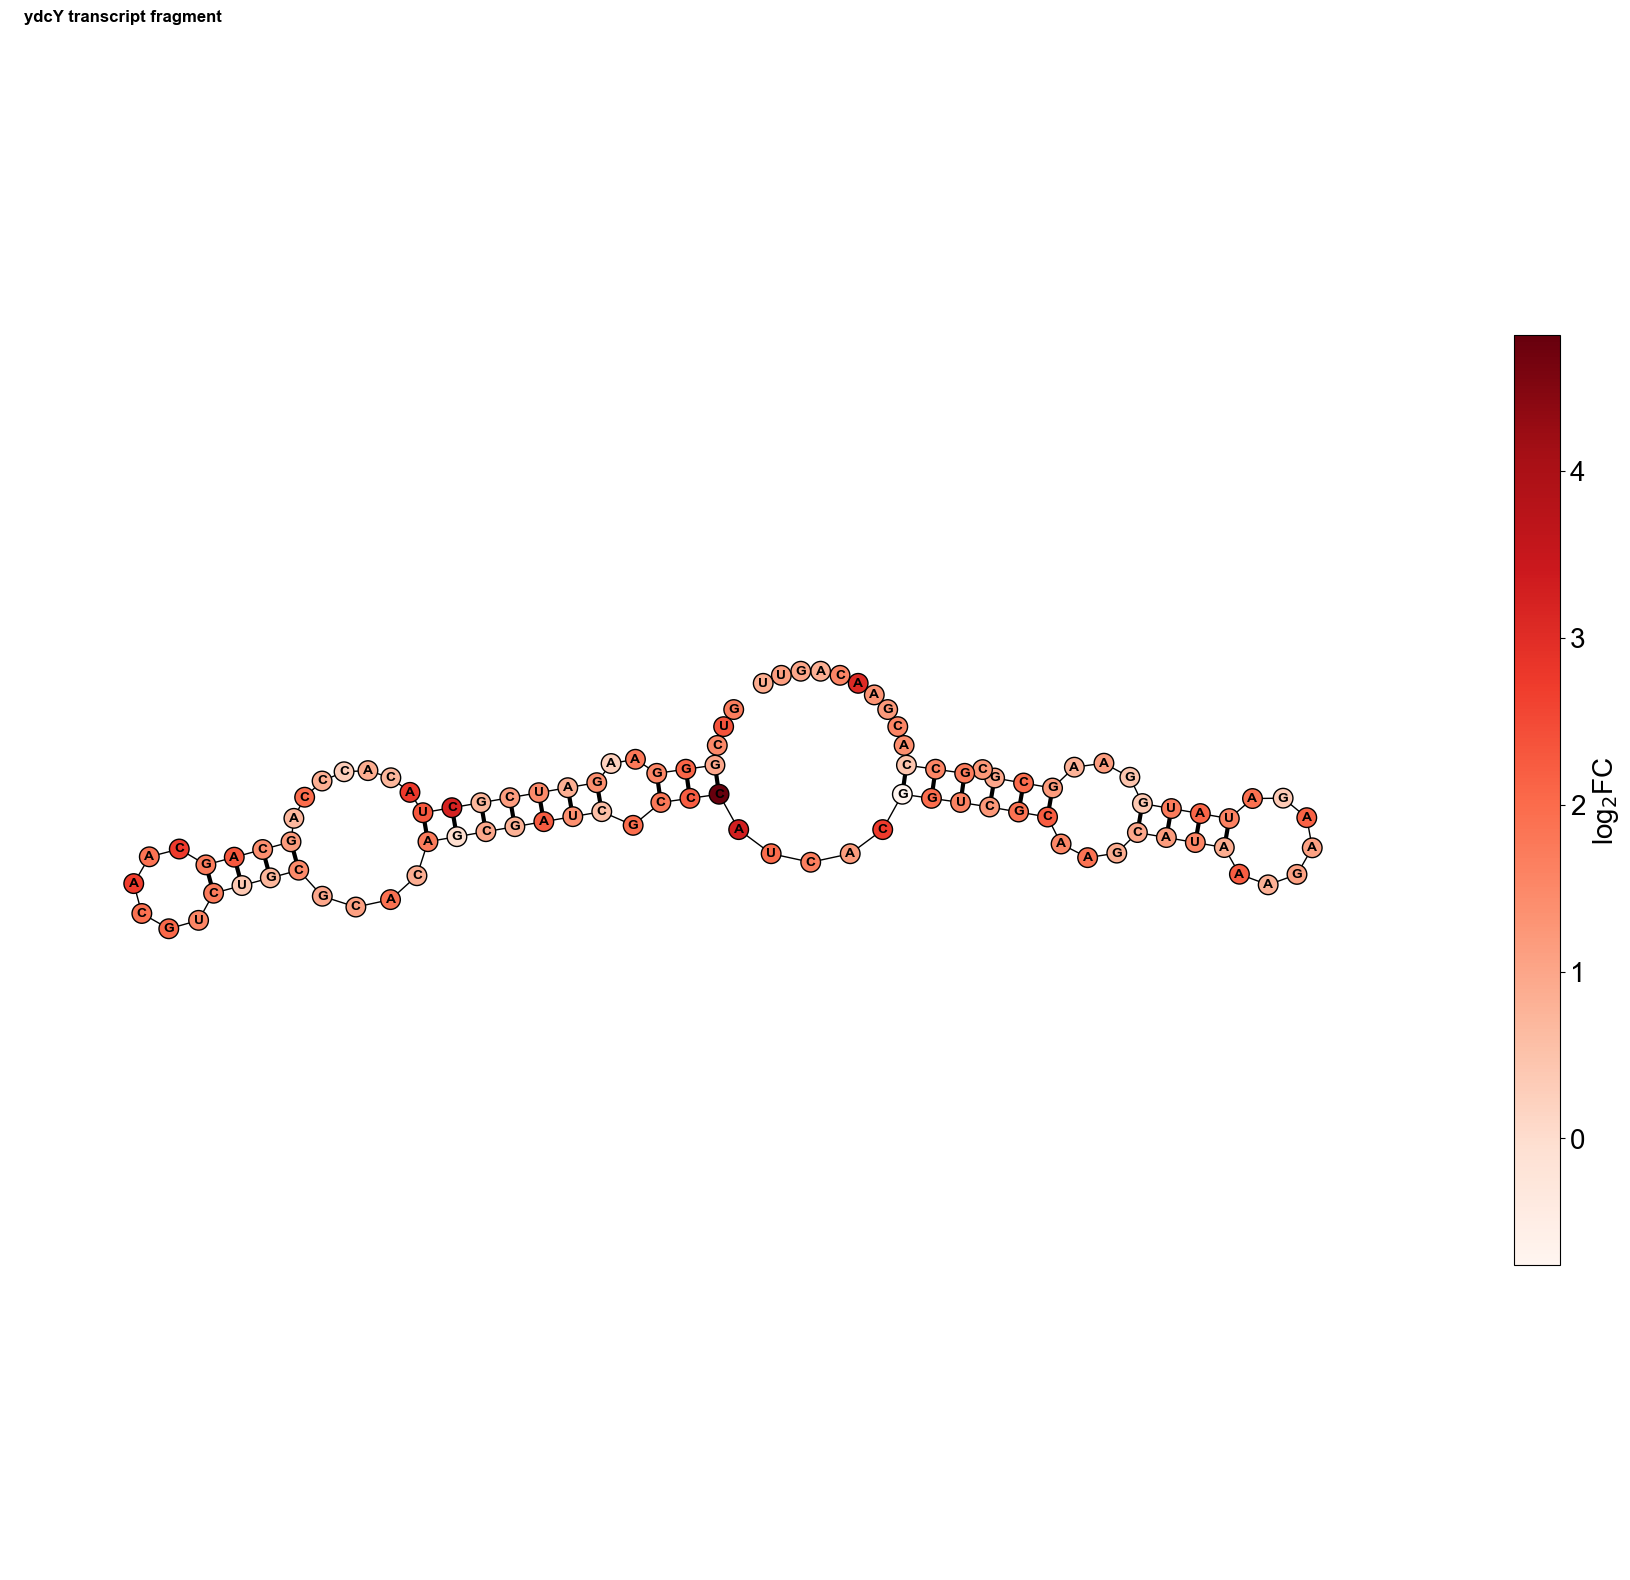

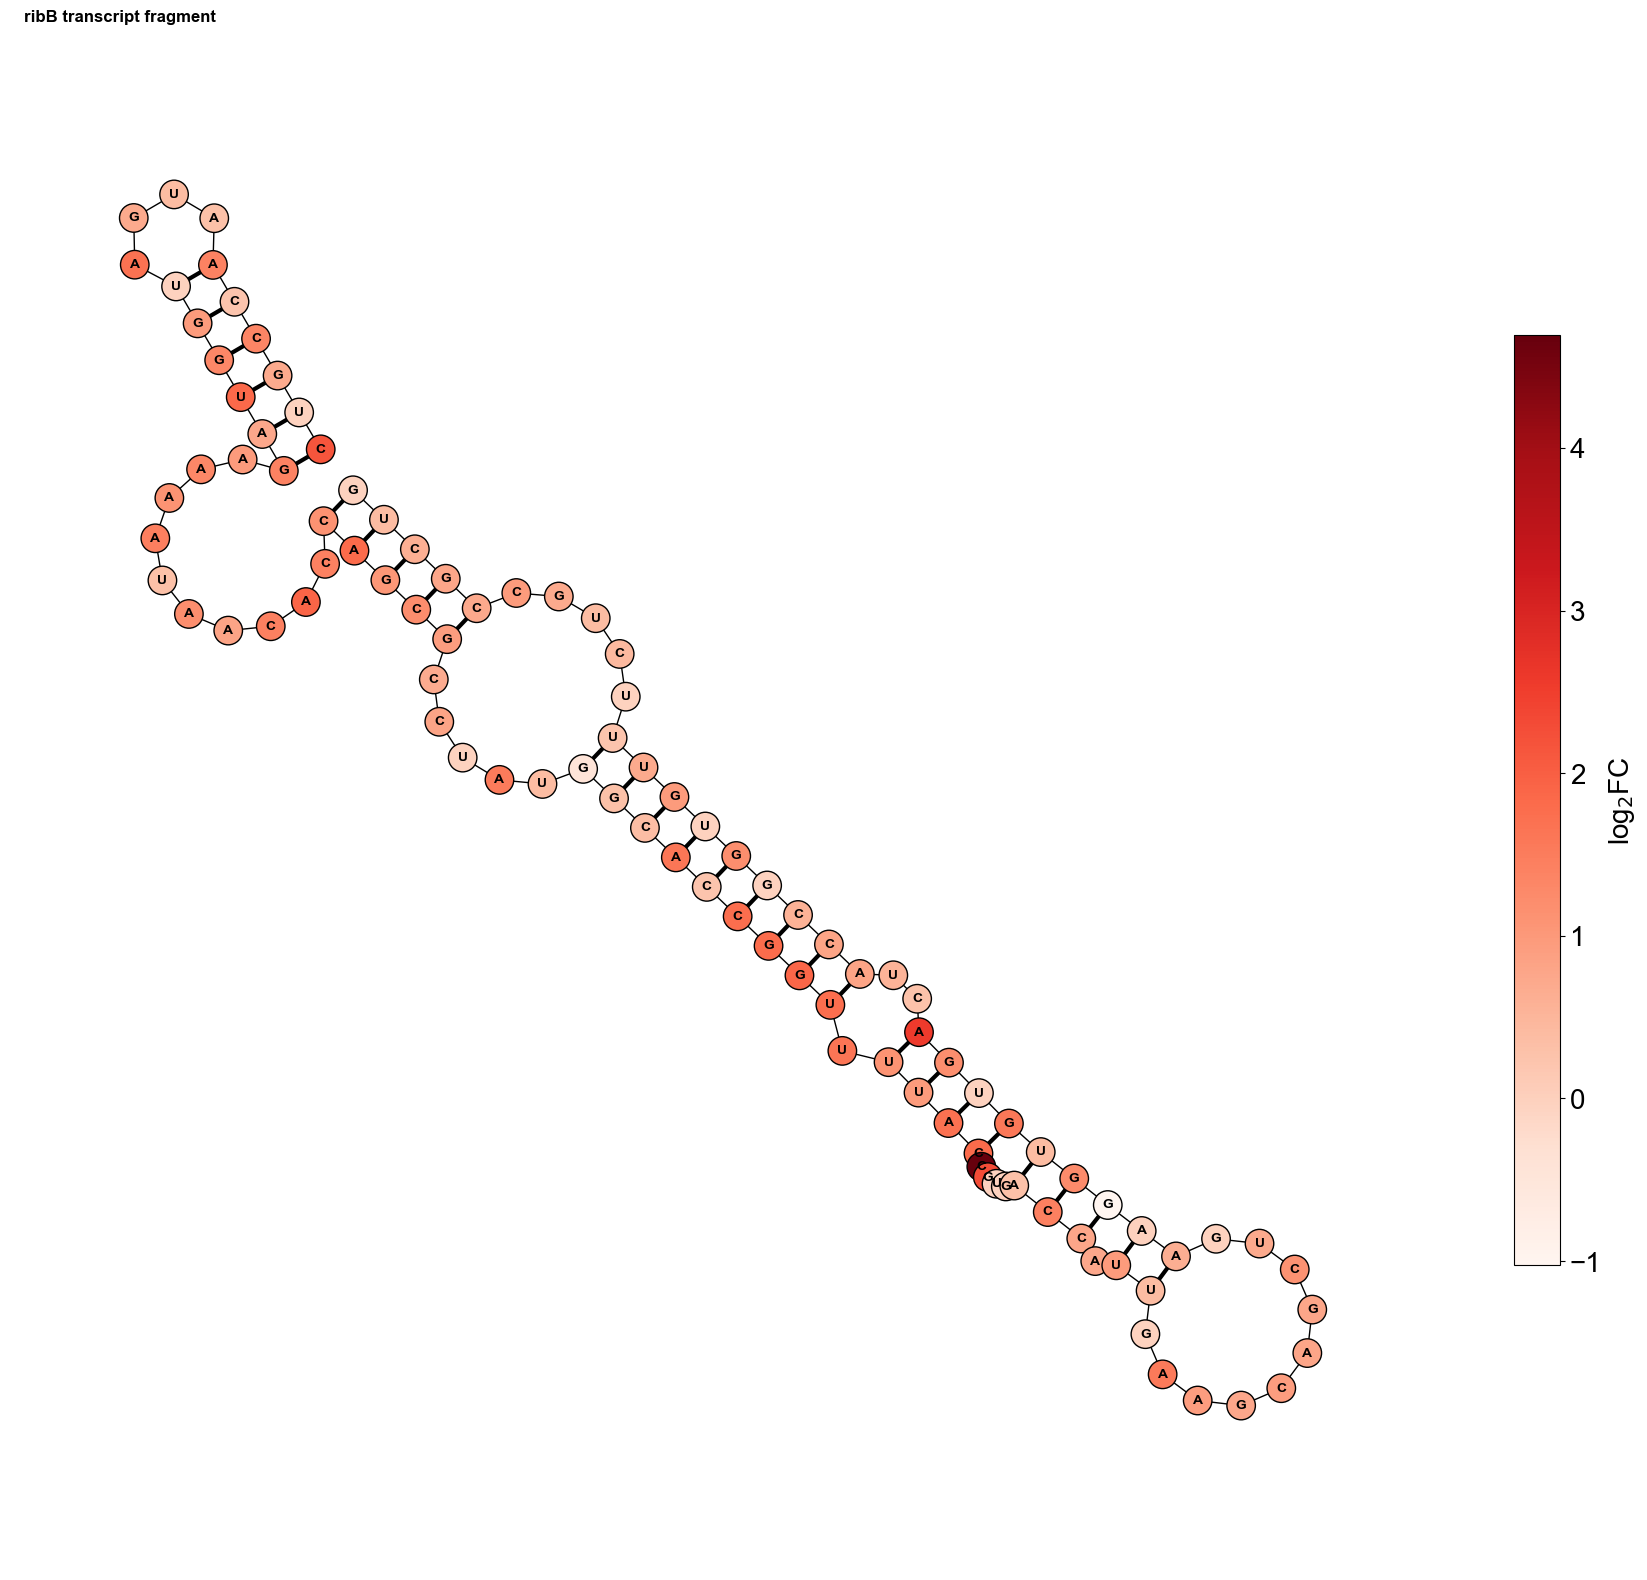

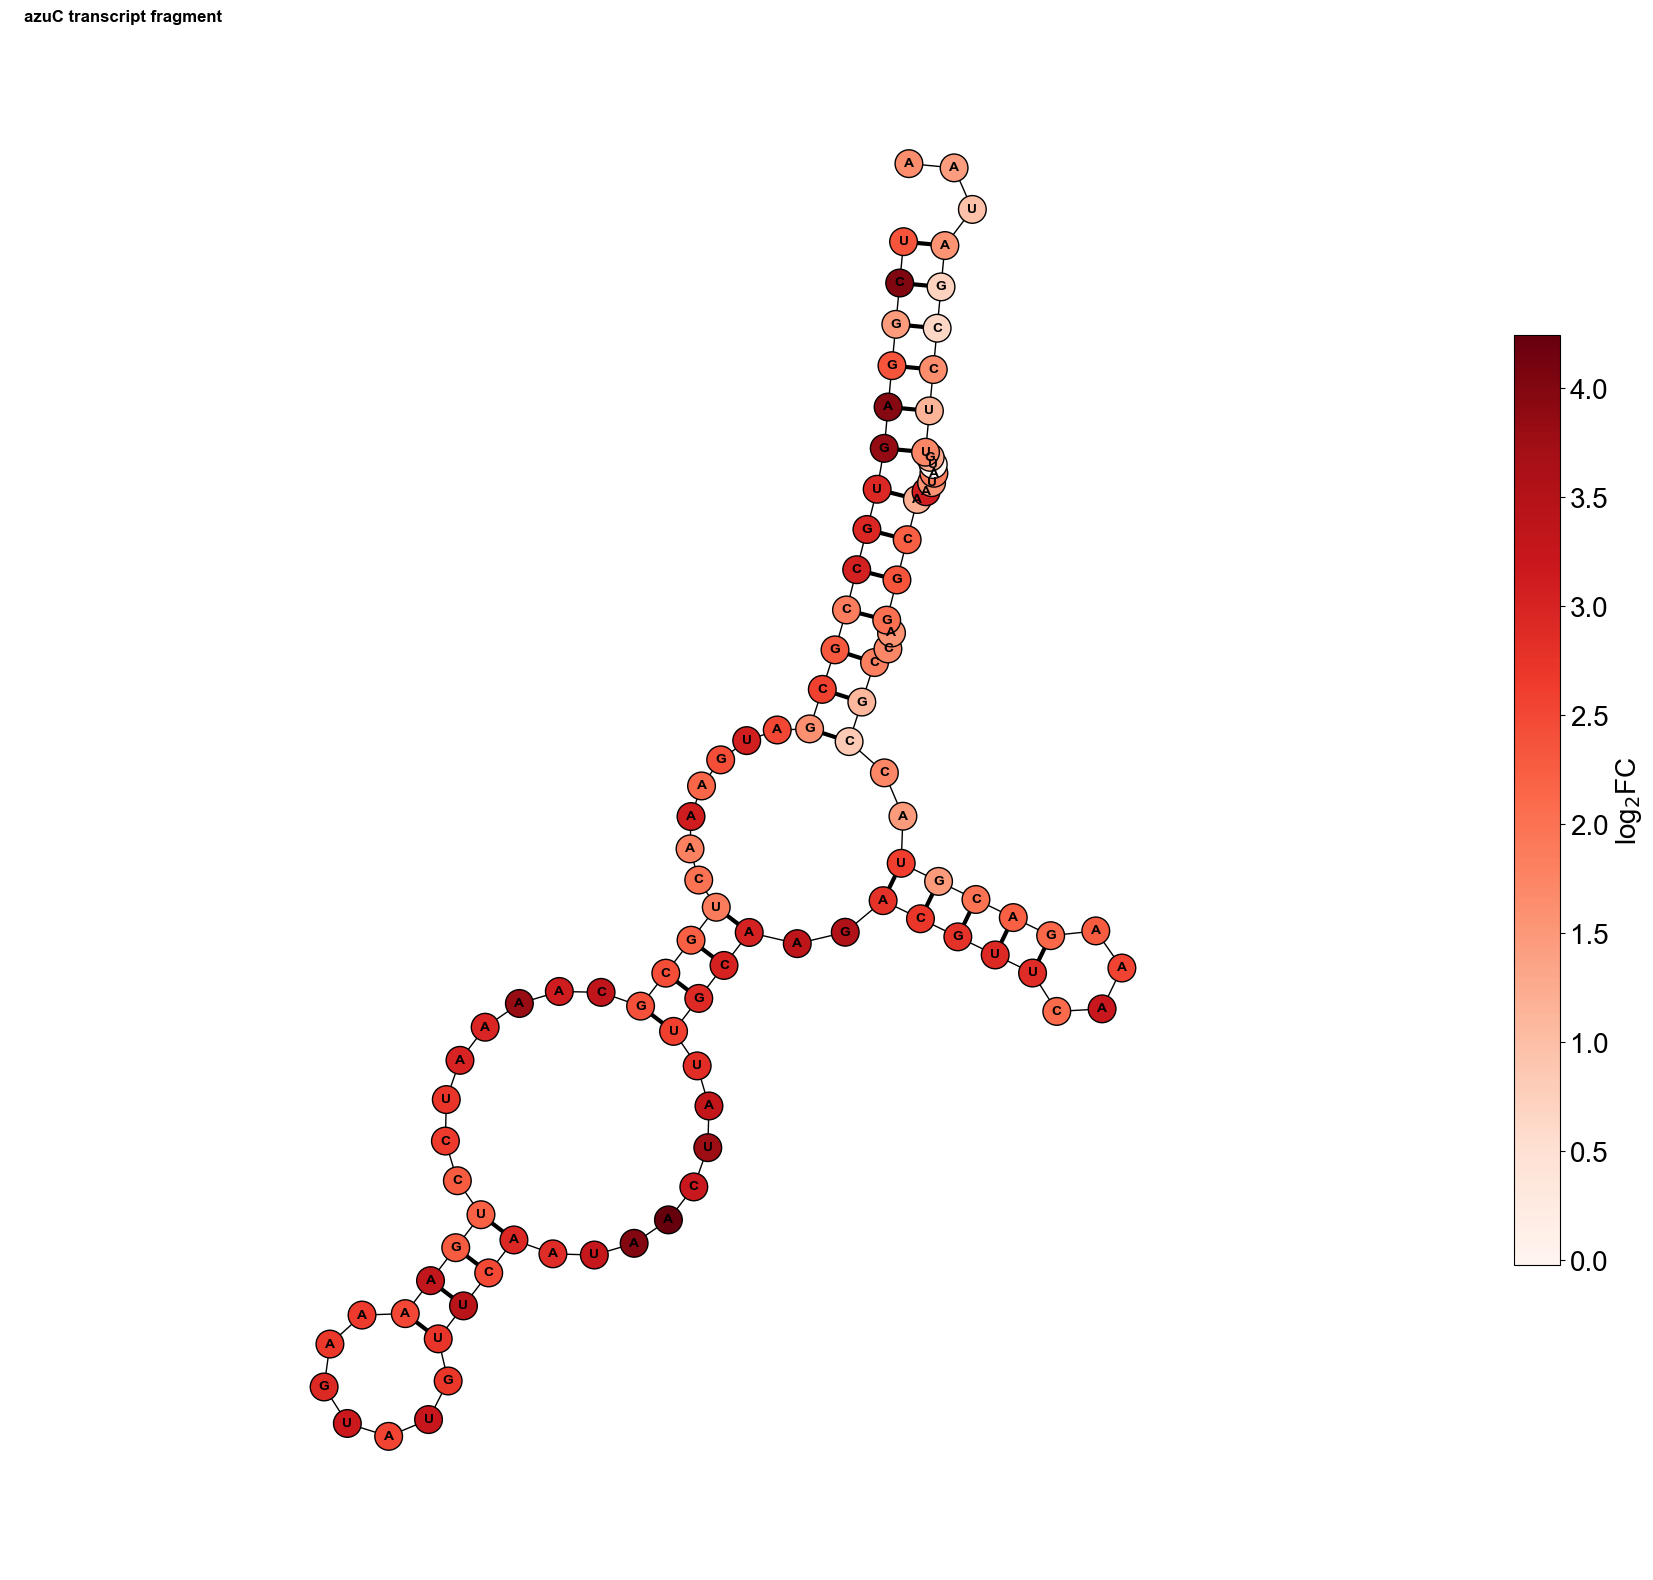

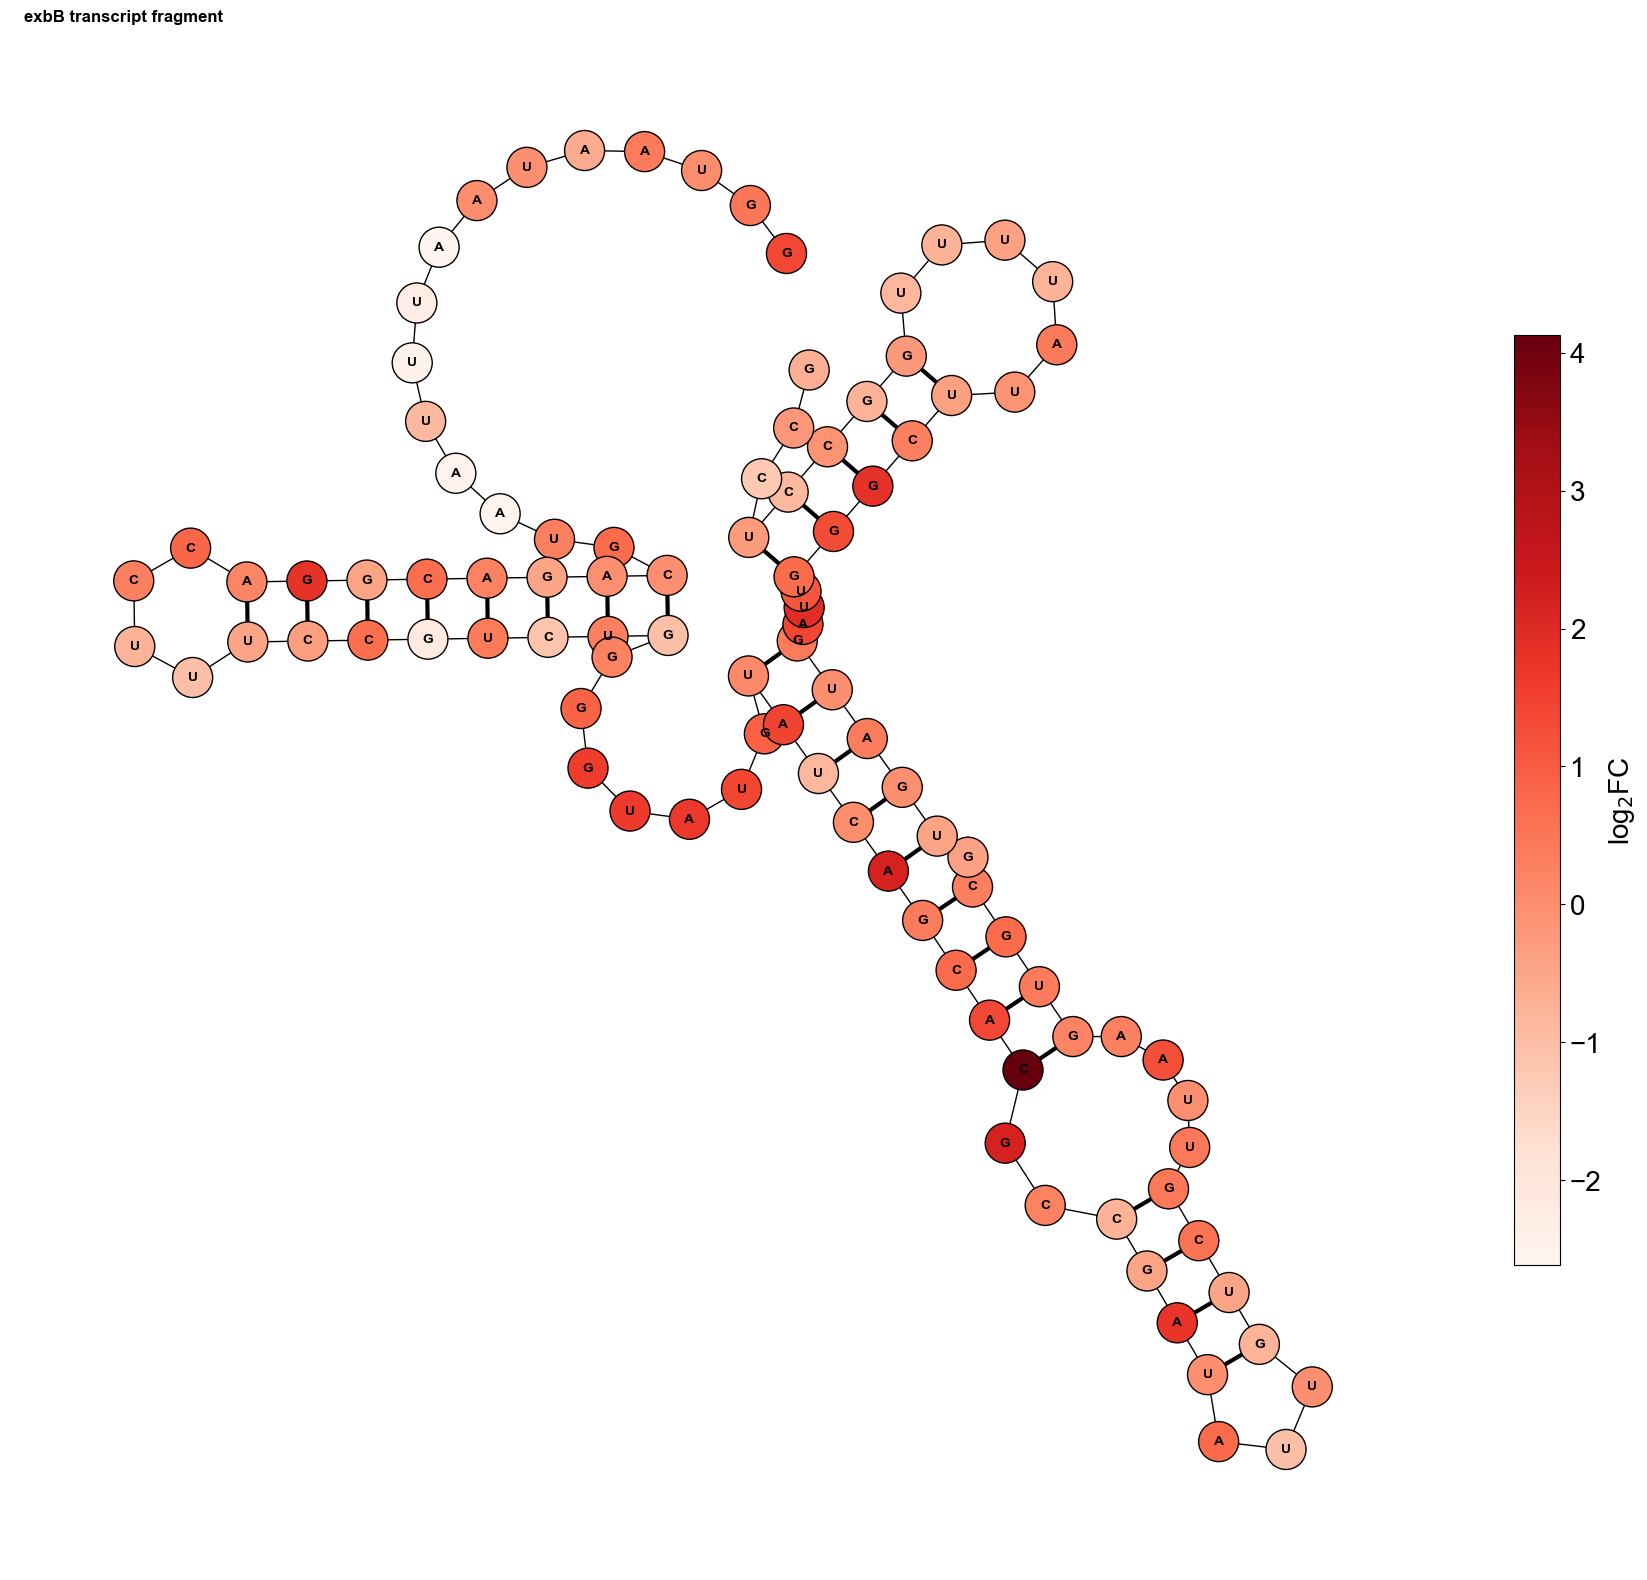

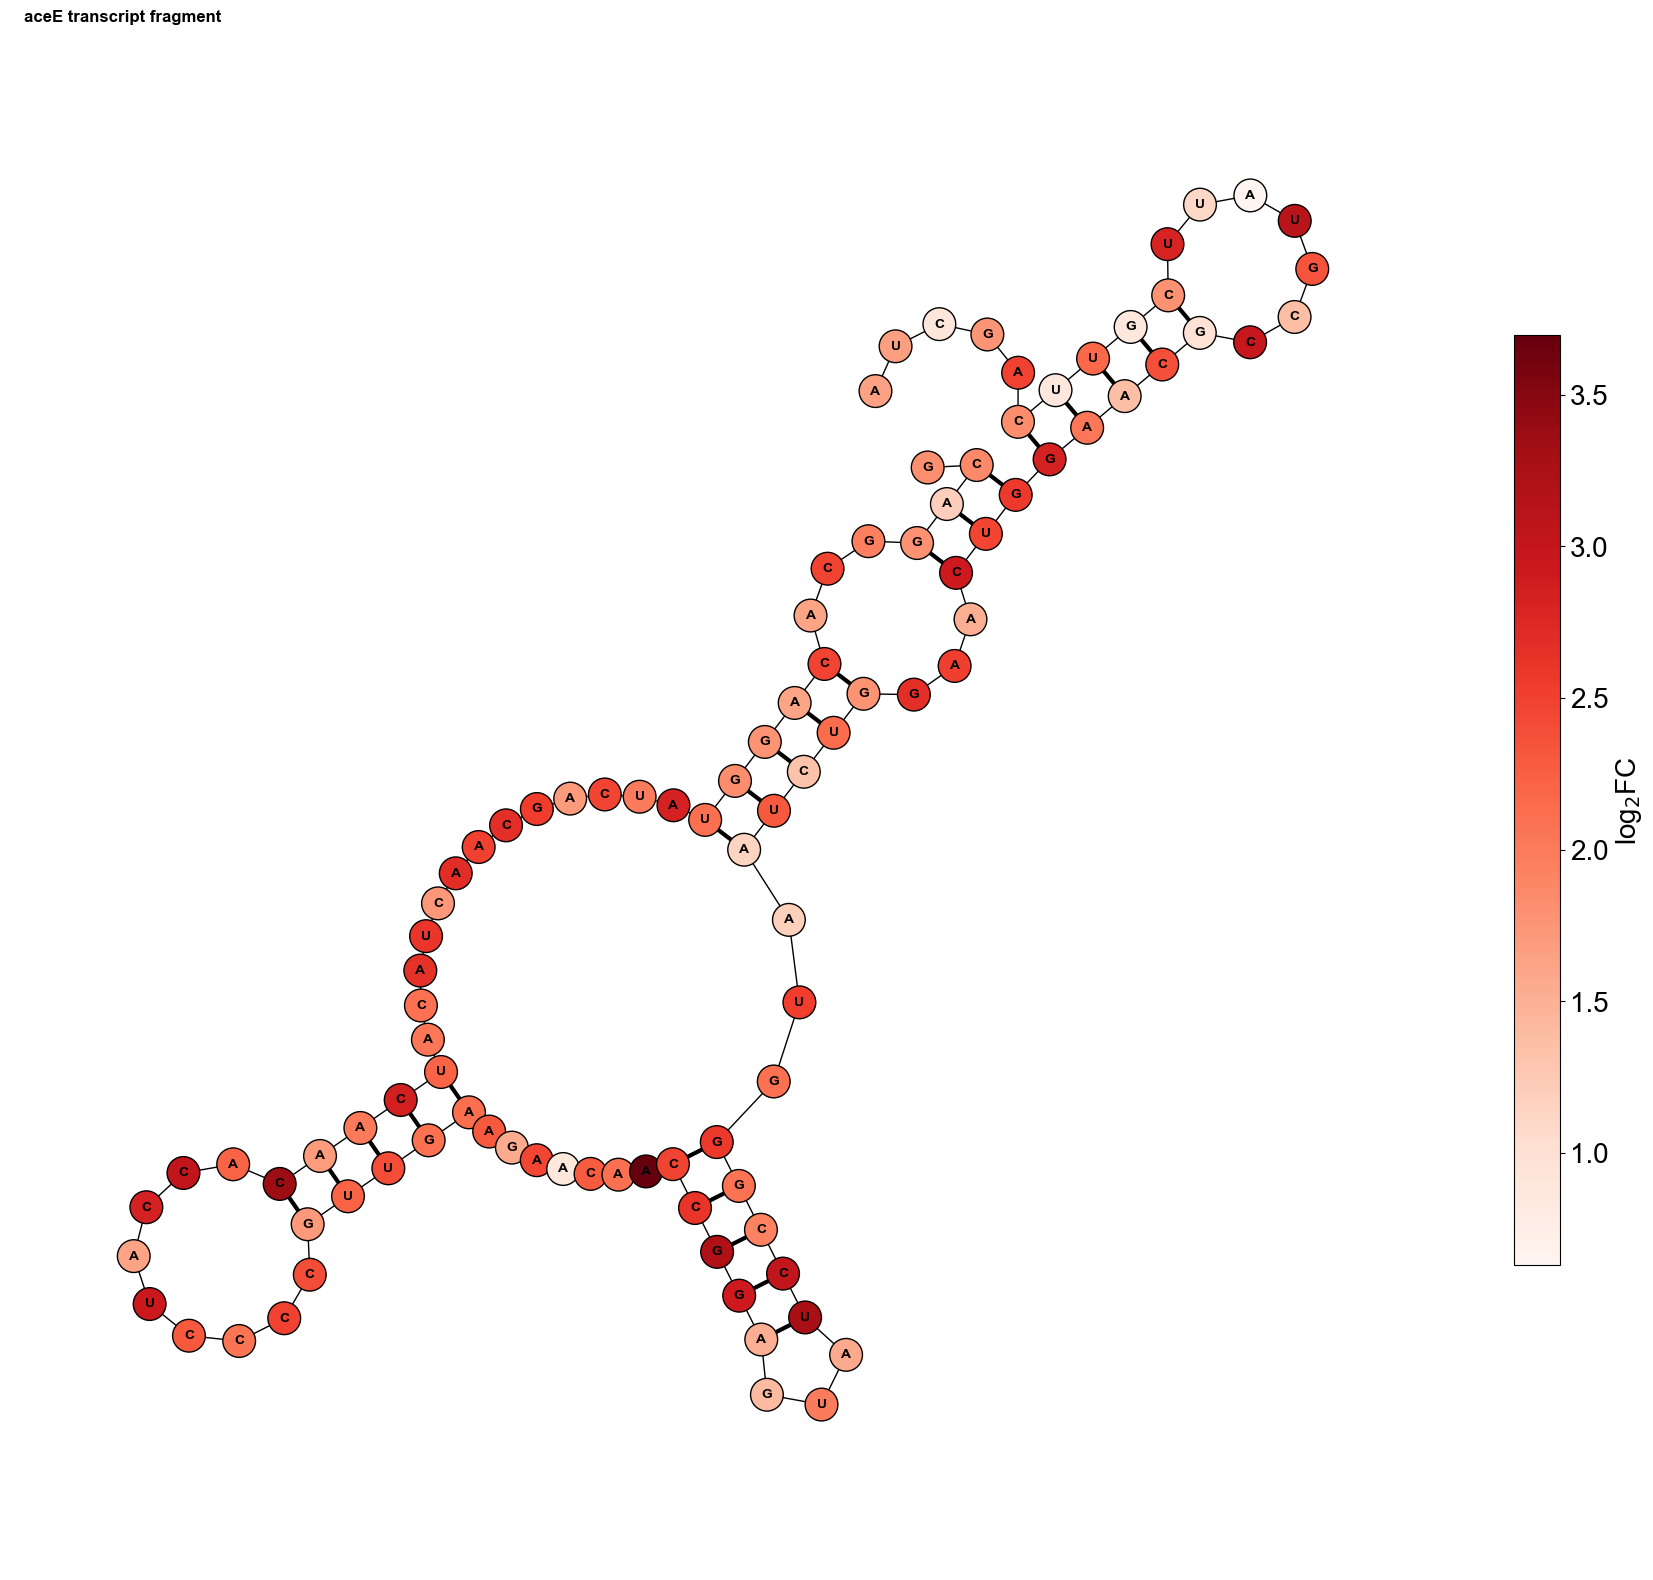

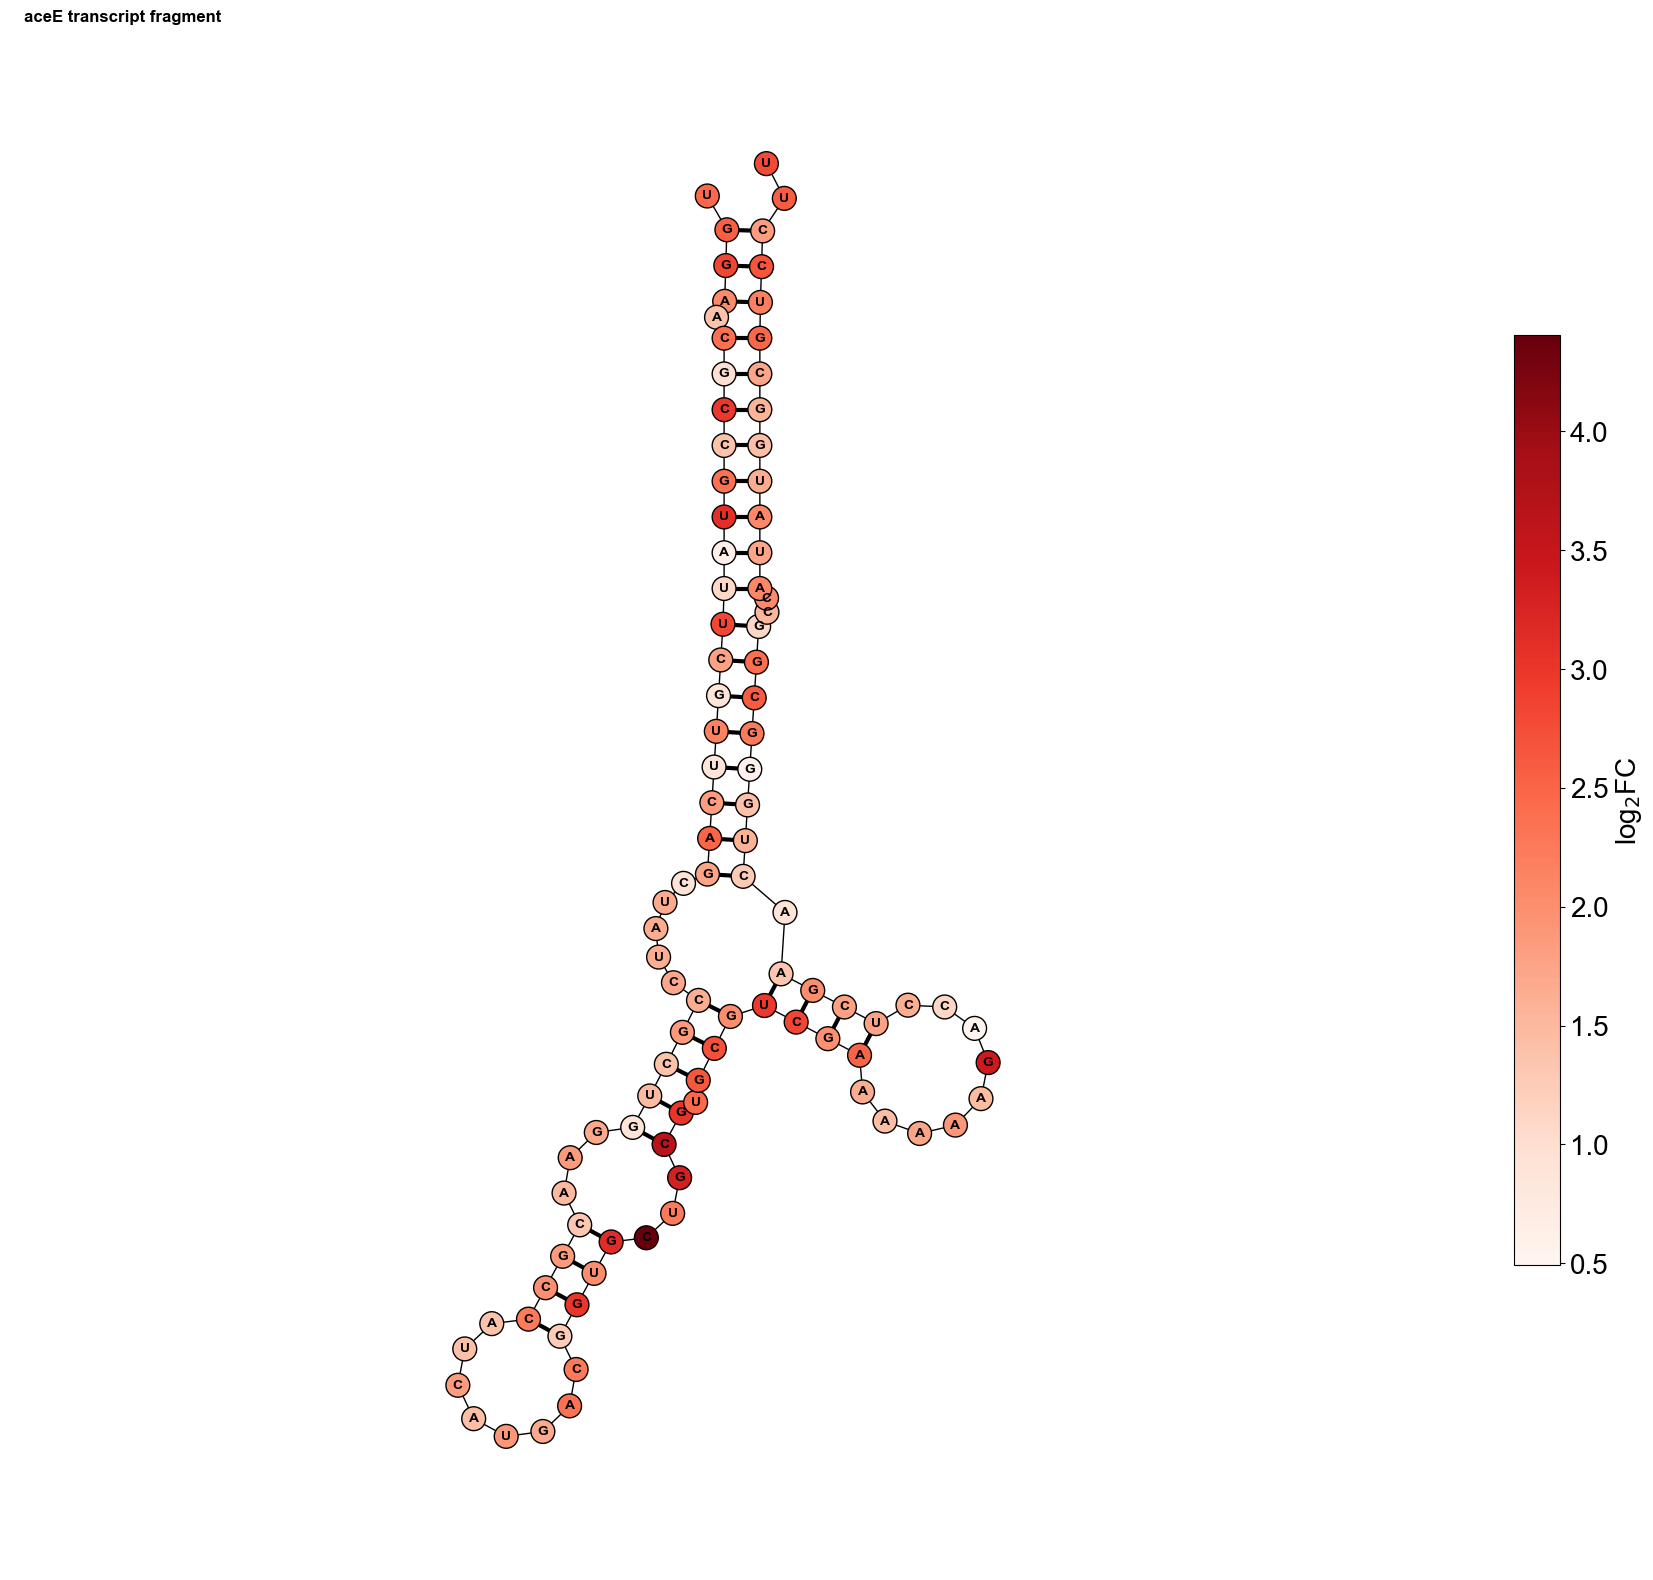

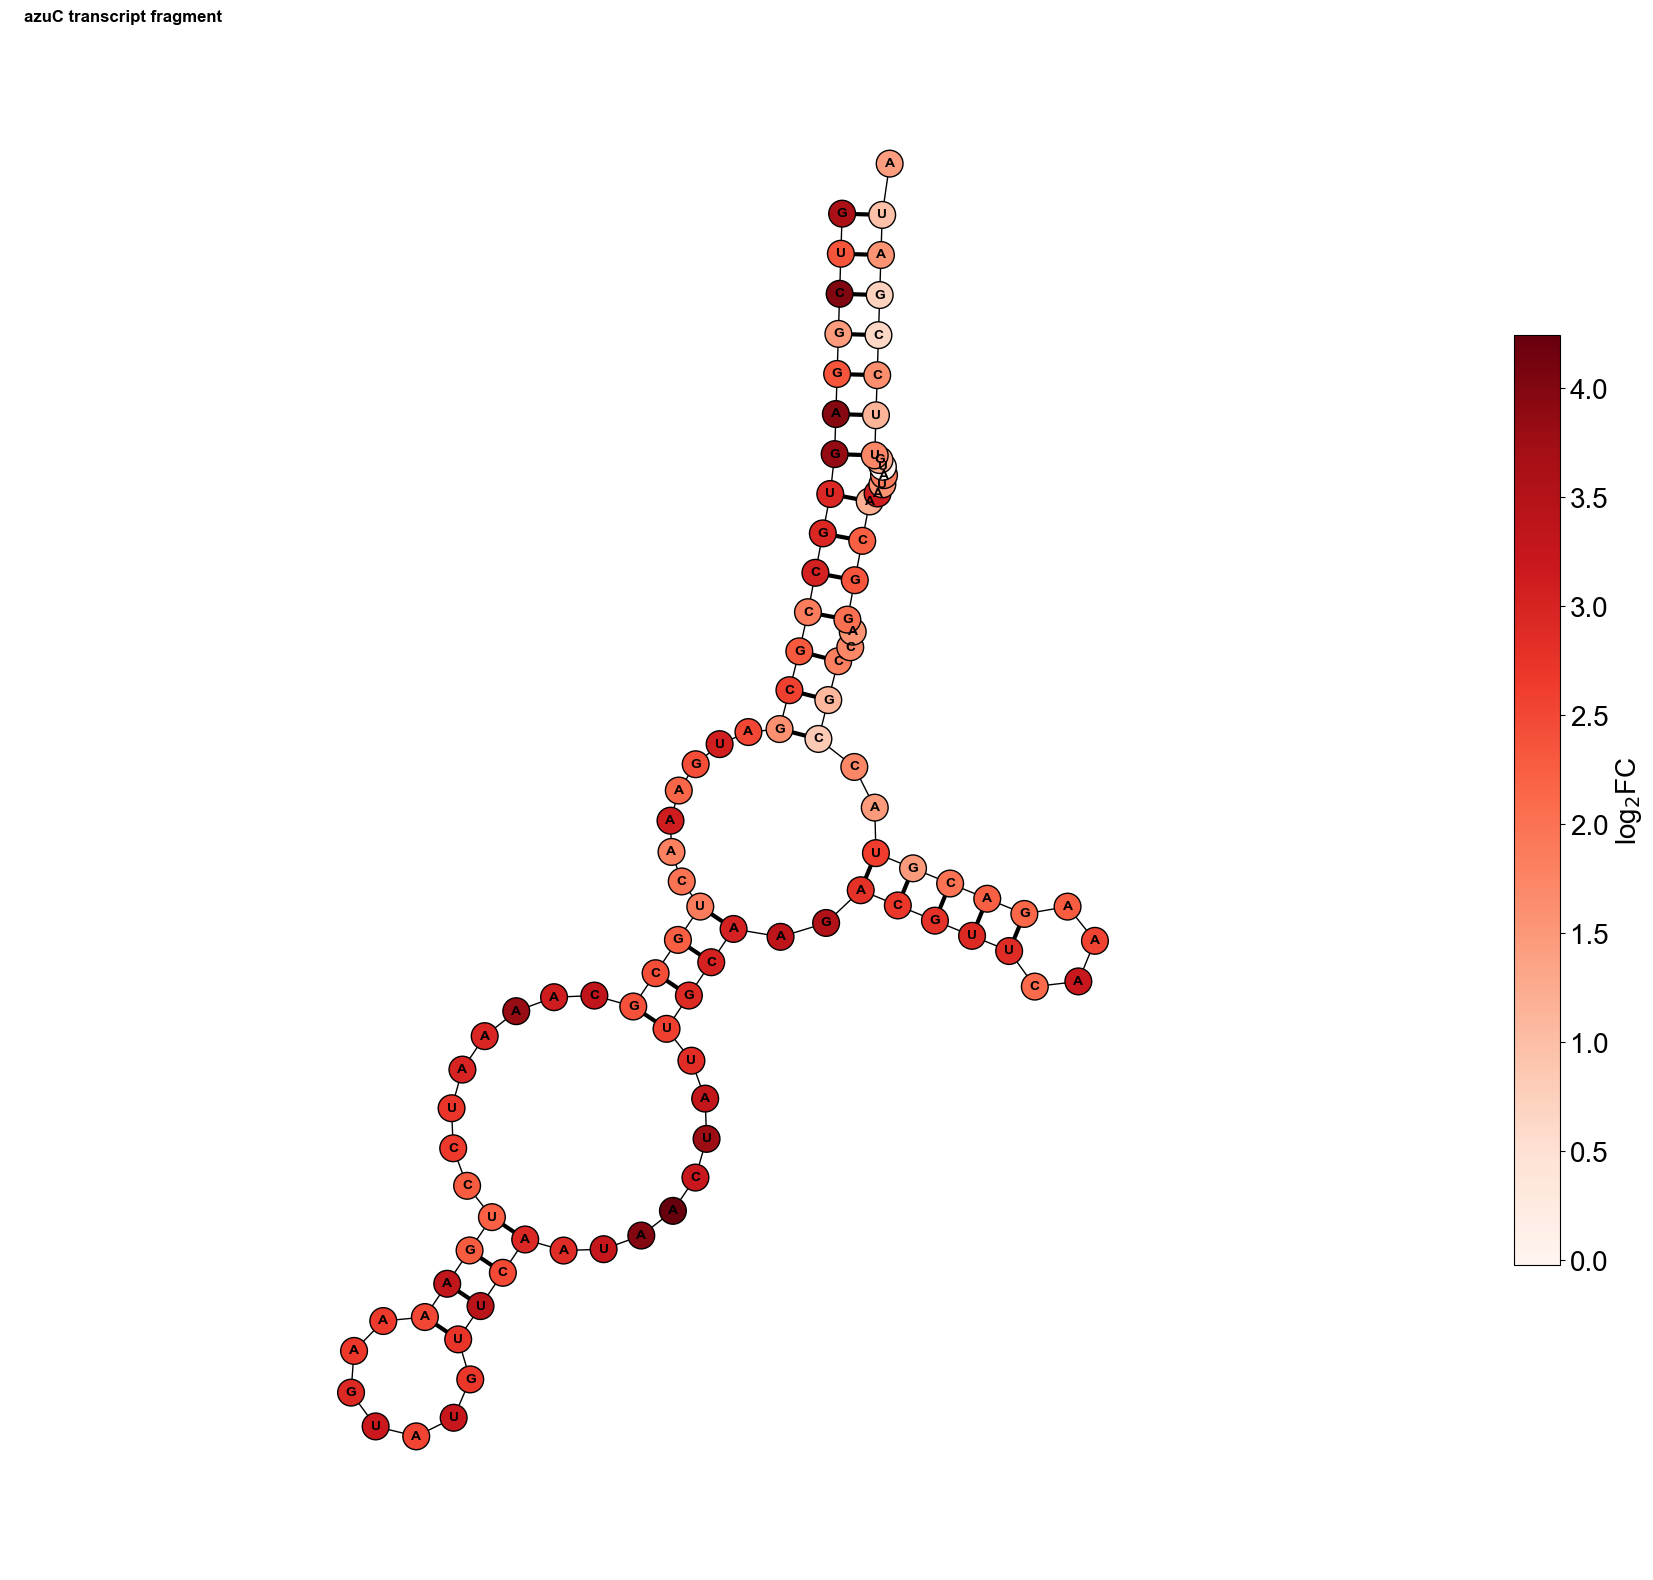

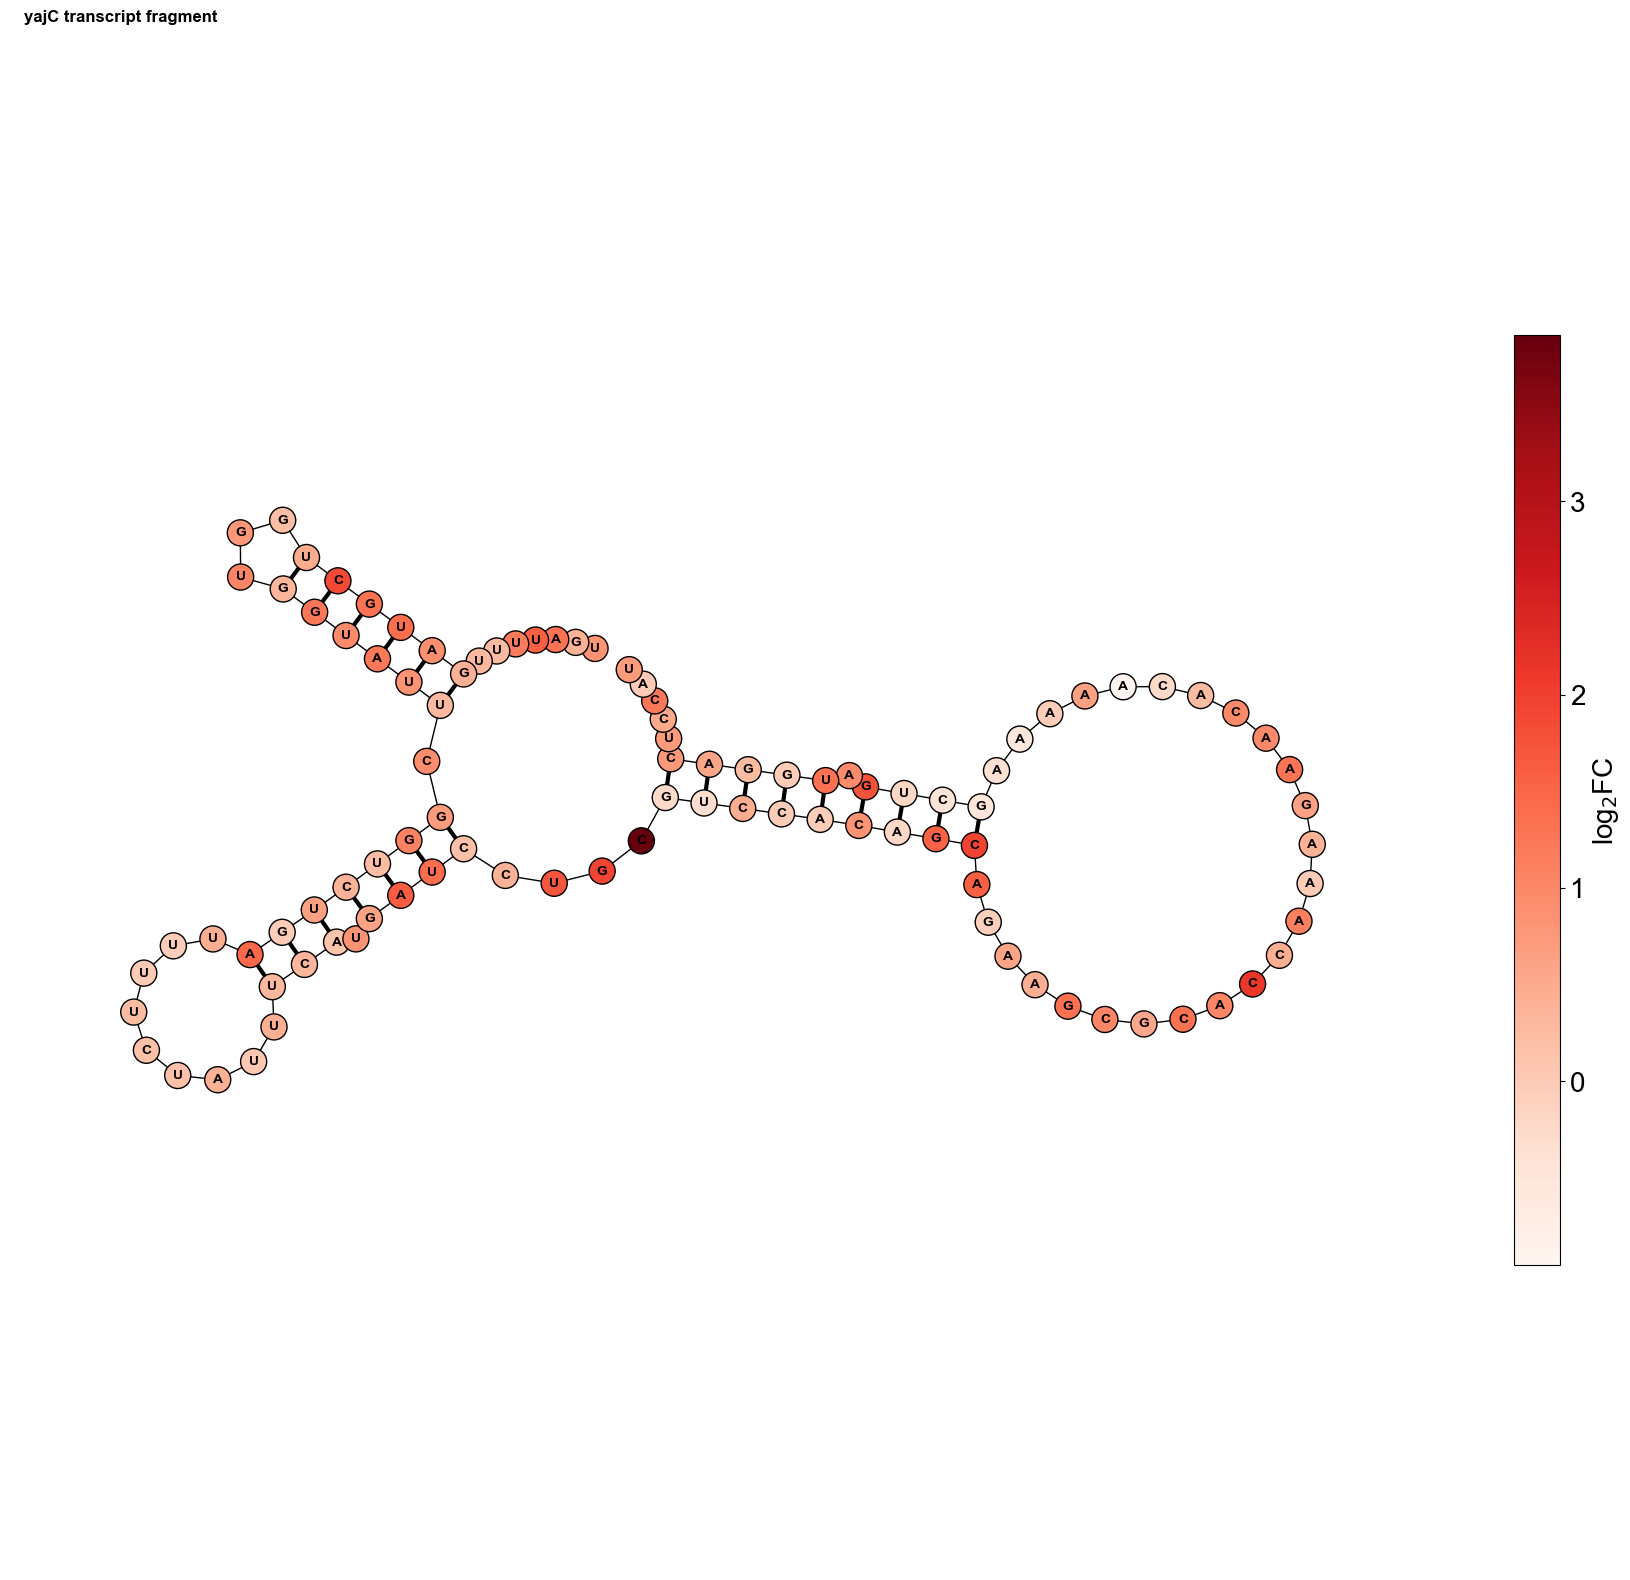

In [12]:
plt.rcParams['font.family'] = 'Arial'

# mRNAStructures = GetColorsAnnotatedRNAStructures(Table=LRTTable[LRTTable["MatchedFeatureType"] != "CDS"].head(10), 
#                                                  Width=20)

mRNAStructures = GetColorsAnnotatedRNAStructures(Table=LRTTable.query("MatchedFeatureType != 'tRNA' and logFC > 0").head(10), 
                                                 Width=50)

for record in mRNAStructures:
    gene = re.search(r"(\w+)_\d+", record["id"]).group(1)
    
    plot_rna_wrapper(record=record, 
                     label=f"{gene} transcript fragment", 
                     outputfilepathprefix=path.join(RNAPicturesDir, record["id"]))